In [74]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor,
                              AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor)
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoost
from sklearn.preprocessing import PolynomialFeatures

from autogluon.tabular import TabularPredictor, TabularDataset

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = "Malgun Gothic"

In [2]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 1004
seed_everything(seed) 

In [3]:
def get_data():
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')

    x_train = train.drop(['ID', '풍속 (m/s)'], axis=1)
    y_train = train['풍속 (m/s)']

    x_test = test.drop(['ID'], axis=1)
    
    le = LabelEncoder()
    le = le.fit(x_train['측정 시간대'])
    x_train['측정 시간대'] = le.transform(x_train['측정 시간대'])
    x_test['측정 시간대'] = le.transform(x_test['측정 시간대'])
    return x_train, y_train, x_test

def test_func(test_model, x_train, y_train, scaler=None):
    if scaler == 'robust':
        scaler = RobustScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    nmse = cross_validate(test_model, x_train_scaled, y_train, scoring=['neg_mean_absolute_error'],
                          return_train_score = True, cv= 5, n_jobs=-1)
    mse = -1 * nmse['test_neg_mean_absolute_error']
    avg_mse = round(np.mean(mse), 4)
    return print(f'MAE : {avg_mse:.4f}')

In [45]:
x_train, y_train, x_test = get_data()

In [46]:
models = [MLPRegressor(random_state=seed),
          LGBMRegressor(random_state=seed),
          XGBRegressor(random_state=seed),
          RandomForestRegressor(random_state=seed),
          BaggingRegressor(random_state=seed),
          ExtraTreesRegressor(random_state=seed)]

for model in models:
    print(model.__class__.__name__, end=' : ')
    test_func(model, x_train, y_train, )

MLPRegressor : MAE : 0.7341
LGBMRegressor : MAE : 0.6000
XGBRegressor : MAE : 0.5404
RandomForestRegressor : MAE : 0.4421
BaggingRegressor : MAE : 0.4680
ExtraTreesRegressor : MAE : 0.3885


In [47]:
test_model = models[1]
test_model.fit(x_train, y_train)

LGBMRegressor(random_state=1004)

In [50]:
pd.DataFrame({'column' : x_train.columns, 'score' : test_model.feature_importances_}).sort_values('score', ascending=False)

,column,score
1,일,590
13,풍향 (deg),453
7,대기압(mbar),428
0,월,305
6,상대 습도 (%),206
12,공기 밀도 (g/m**3),174
5,이슬점 온도(°C),162
2,측정 시간대,132
10,증기압 부족량(mbar),131
3,섭씨 온도(°⁣C),106


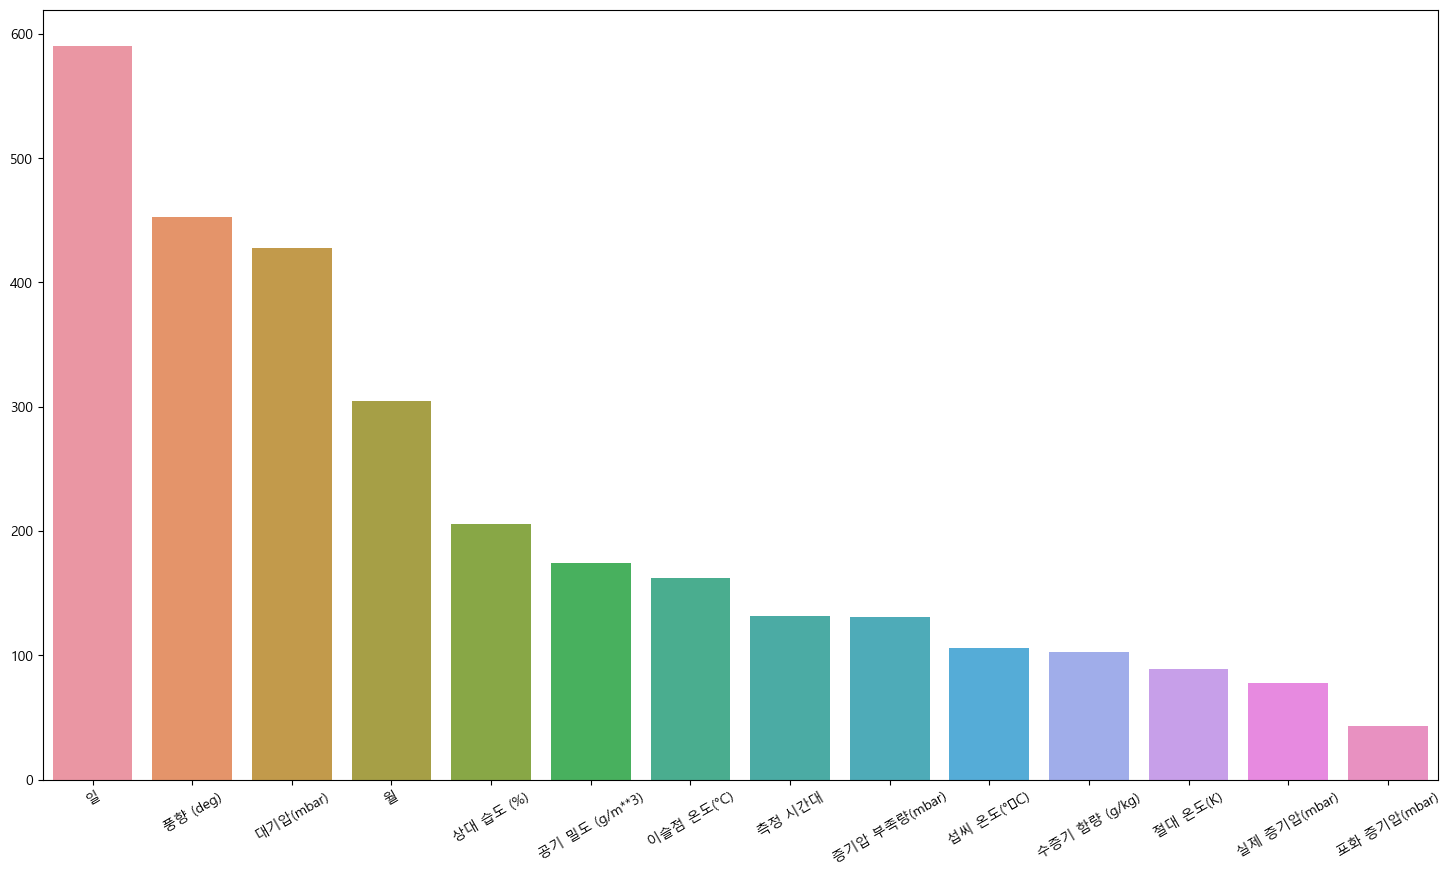

In [51]:
ftr_importances = pd.Series(test_model.feature_importances_, index=x_train.columns).sort_values(ascending=False)
plt.figure(figsize=(18, 10))
sns.barplot(x = ftr_importances.index, y=ftr_importances)
plt.xticks(rotation=30)
plt.show()

In [32]:
def feature_drop(drop_cols, model, return_data=True, scaler=None):
    x_train, y_train, x_test = get_data()
    x_train = x_train.drop(drop_cols, axis=1)
    test_func(model, x_train, y_train, scaler=scaler)
    if return_data:
        return x_train, y_train, x_test
    else:
        return

In [53]:
drop_col_lists = [['실제 증기압(mbar)', '증기압 부족량(mbar)'],
                  ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)'],
                  ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)'],
                  ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)'],
                  ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)','측정 시간대'],
                  ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)']         
                 ]
for idx, drop_cols in enumerate(drop_col_lists):
    if idx == len(drop_col_lists) -1:
        x_train, y_train, x_test = get_data()
        x_train.drop(drop_cols, axis=1, inplace=True)
        poly = PolynomialFeatures(3)
        x_train_poly = poly.fit_transform(x_train)
        print(f'{idx}번 째 삭제할 열들 : {drop_cols}')
        test_func(models[-1], x_train_poly, y_train)

    else:
        print(f'{idx}번 째 삭제할 열들 : {drop_cols}')
        feature_drop(drop_cols, models[-1], return_data=False)
    

0번 째 삭제할 열들 : ['실제 증기압(mbar)', '증기압 부족량(mbar)']
MAE : 0.3856
1번 째 삭제할 열들 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)']
MAE : 0.3838
2번 째 삭제할 열들 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)']
MAE : 0.3840
3번 째 삭제할 열들 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)']
MAE : 0.3822
4번 째 삭제할 열들 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)', '측정 시간대']
MAE : 0.3897
5번 째 삭제할 열들 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)']
MAE : 0.4004


In [54]:
def get_new_col(df, new_cols):
    cal_train = df.copy(deep=True)
    for i in new_cols:
        split_col = i.split('*')
        if len(split_col) >= 2:
            col_name = ''
            for j in range(len(split_col)):
                if j==0:
                    col_name = split_col[j]
                    cal_train['cal'] = cal_train[col_name]
                else:
                    col_name += f'*{split_col[j]}'
                    cal_train['cal'] *= cal_train[split_col[j]]
            df[col_name] = cal_train['cal']
    return df

In [55]:
x_train, y_train, x_test = get_data()
x_train.drop(['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)'], axis=1, inplace=True)
x_train.tail(2)

,월,일,측정 시간대,이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),수증기 함량 (g/kg),풍향 (deg)
36579,9,10,3,15.30,52.81,988.39,32.98,11.03,225.40
36580,3,11,1,1.88,91.40,1000.01,7.66,4.37,30.67


In [57]:
def feature_engineering(new_cols, drop_cols, model, return_data=True, scaler=None):
    print(f'삭제한 열 : {drop_cols}')
    print('이 때 성능 : ', end = '')
    x_train, y_train, x_test = feature_drop(drop_cols, model, return_data, scaler)
    df = get_new_col(x_train, new_cols)
    print('새로운 열 생성 후 성능')
    test_func(model, df, y_train)
    return df

In [59]:
drop_cols = ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)']
new_cols = ['월*일', '대기압(mbar)*풍향 (deg)', '월*대기압(mbar)', '월*풍향 (deg)']
x_train_new = feature_engineering(new_cols, drop_cols, models[-1])

삭제한 열 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)']
이 때 성능 : MAE : 0.3822
새로운 열 생성 후 성능
MAE : 0.3890


In [60]:
drop_cols = ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)']
new_cols = ['대기압(mbar)*포화 증기압(mbar)']
x_train_new = feature_engineering(new_cols, drop_cols, models[-1])

삭제한 열 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)']
이 때 성능 : MAE : 0.3822
새로운 열 생성 후 성능
MAE : 0.3826


In [61]:
drop_cols = ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)']
new_cols = ['월*일']
x_train_new = feature_engineering(new_cols, drop_cols, models[-1])

삭제한 열 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)']
이 때 성능 : MAE : 0.3822
새로운 열 생성 후 성능
MAE : 0.3770


In [62]:
drop_cols = ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)',
              '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)', '수증기 함량 (g/kg)']
new_cols = ['월*일']
x_train_new = feature_engineering(new_cols, drop_cols, models[-1])

삭제한 열 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)', '수증기 함량 (g/kg)']
이 때 성능 : MAE : 0.3819
새로운 열 생성 후 성능
MAE : 0.3775


In [63]:
drop_cols = ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)']
new_cols = ['월*대기압(mbar)']
x_train_new = feature_engineering(new_cols, drop_cols, models[-1])

삭제한 열 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)']
이 때 성능 : MAE : 0.3822
새로운 열 생성 후 성능
MAE : 0.3767


In [64]:
drop_cols = ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)']
new_cols = ['일*대기압(mbar)']
x_train_new = feature_engineering(new_cols, drop_cols, models[-1])

삭제한 열 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)']
이 때 성능 : MAE : 0.3822
새로운 열 생성 후 성능
MAE : 0.3746


In [65]:
drop_cols = ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)']
new_cols = ['월*일', '일*대기압(mbar)']
x_train_new = feature_engineering(new_cols, drop_cols, models[-1])

삭제한 열 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)']
이 때 성능 : MAE : 0.3822
새로운 열 생성 후 성능
MAE : 0.3720


In [67]:
drop_cols = ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)',
              '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)', '수증기 함량 (g/kg)']
new_cols = ['월*일', '일*대기압(mbar)', '월*대기압(mbar)']
x_train_new = feature_engineering(new_cols, drop_cols, models[-1])

삭제한 열 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)', '수증기 함량 (g/kg)']
이 때 성능 : MAE : 0.3819
새로운 열 생성 후 성능
MAE : 0.3692


In [68]:
drop_cols = ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)']
new_cols = ['월*일', '일*대기압(mbar)', '월*대기압(mbar)']
x_train_new = feature_engineering(new_cols, drop_cols, models[-1])

삭제한 열 : ['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°\u2063C)']
이 때 성능 : MAE : 0.3822
새로운 열 생성 후 성능
MAE : 0.3690


In [69]:
x_train_new.tail(2)

,월,일,측정 시간대,이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),수증기 함량 (g/kg),풍향 (deg),월*일,일*대기압(mbar),월*대기압(mbar)
36579,9,10,3,15.30,52.81,988.39,32.98,11.03,225.40,90,9883.90,8895.51
36580,3,11,1,1.88,91.40,1000.01,7.66,4.37,30.67,33,11000.11,3000.03


In [70]:
col_list = list(x_train_new)
col_list[-3] = '월_일'
col_list[-2] = '일_대기압'
col_list[-1] = '월_대기압'
x_train_new.columns = col_list

In [71]:
x_train_new_re = get_new_col(x_train_new, ['월_일*일_대기압'])
test_func(models[-1], x_train_new_re, y_train)

MAE : 0.3679


In [72]:
x_train_new_re = get_new_col(x_train_new, ['월_대기압*일_대기압'])
test_func(models[-1], x_train_new_re, y_train)

MAE : 0.3667


In [73]:
x_train_new_re = get_new_col(x_train_new, ['월_일*월_대기압', '월_대기압*일_대기압'])
test_func(models[-1], x_train_new_re, y_train)

MAE : 0.3660


In [75]:
x_train, y_train, x_test = get_data()
x_train.drop(['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)'], axis=1, inplace=True)
x_test.drop(['실제 증기압(mbar)', '증기압 부족량(mbar)', '절대 온도(K)', '공기 밀도 (g/m**3)', '섭씨 온도(°⁣C)'], axis=1, inplace=True)

x_train_new = get_new_col(x_train, ['월*일', '일*대기압(mbar)', '월*대기압(mbar)'])
x_test_new = get_new_col(x_test, ['월*일', '일*대기압(mbar)', '월*대기압(mbar)'])

col_list = list(x_train_new.columns)
col_list[-3] = '월_일'
col_list[-2] = '일_대기압'
col_list[-1] = '월_대기압'
x_train_new.columns = col_list
x_train_new_2 = get_new_col(x_train_new, ['월_일*월_대기압', '월_대기압*일_대기압'])
x_test_new.columns = col_list
x_test_new_2 = get_new_col(x_test_new, ['월_일*월_대기압', '월_대기압*일_대기압'])

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_new_2)
x_test_scaled = scaler.transform(x_test_new_2)

train = pd.DataFrame(x_train_scaled)
train['TARGET'] = y_train

In [77]:
predictor = TabularPredictor(label='TARGET', eval_metric='mae', problem_type='regression')
predictor.fit(train_data=train, presets='best_quality', num_stack_levels=3,)

No path specified. Models will be saved in: "AutogluonModels\ag-20230817_140101\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230817_140101\"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   838.85 GB / 1000.19 GB (83.9%)
Train Data Rows:    36581
Train Data Columns: 14
Label Column: TARGET
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    23447.8 MB
	Train Data (Original)  Memory Usage: 4.1 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator..

KeyboardInterrupt: 

In [ ]:
test = pd.DataFrame(x_test_scaled)
preds = predictor.predict(test)

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['풍속 (m/s)'] = preds
submission.to_csv('data/1st_submission.csv', index=False)